<a href="https://colab.research.google.com/github/ansar2019/image-captionig/blob/main/OFA_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone OFA if there does not exist the repo
%cd /content
!git clone https://github.com/OFA-Sys/OFA.git


/content
Cloning into 'OFA'...
remote: Enumerating objects: 6685, done.
remote: Counting objects: 100% (1326/1326), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 6685 (delta 1011), reused 951 (delta 932), pack-reused 5359
Receiving objects: 100% (6685/6685), 122.81 MiB | 30.20 MiB/s, done.
Resolving deltas: 100% (2844/2844), done.


In [2]:
%cd /content
!mkdir -p /content/OFA/checkpoints/
!wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/checkpoints/caption_base_best.pt
!mv caption_base_best.pt OFA/checkpoints/caption.pt


/content
--2023-12-25 08:59:12--  https://ofa-beijing.oss-cn-beijing.aliyuncs.com/checkpoints/caption_base_best.pt
Resolving ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)... 59.110.190.134
Connecting to ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)|59.110.190.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2254237467 (2.1G) [application/octet-stream]
Saving to: ‘caption_base_best.pt’

caption_base_best.p 100%[===================>]   2.10G  13.6MB/s    in 2m 45s  

2023-12-25 09:01:58 (13.0 MB/s) - ‘caption_base_best.pt’ saved [2254237467/2254237467]



In [3]:
# clone Fairseq for installation
%cd /content
!git clone https://github.com/pytorch/fairseq.git -b v0.12.0
%cd /content/fairseq
!pip install fairseq

/content
Cloning into 'fairseq'...
remote: Enumerating objects: 34968, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 34968 (delta 80), reused 79 (delta 52), pack-reused 34850
Receiving objects: 100% (34968/34968), 25.12 MiB | 23.32 MiB/s, done.
Resolving deltas: 100% (25387/25387), done.
Note: switching to '6795311bfeb9d39fe11a62803184b81acb66509e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/fairseq
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%cd /content/OFA
!sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 889.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41929 sha256=ec67cadb1782909ee7547fe718b36f43d3989a5e3ae719ab9bb248ff06d0c205
  Stored in directory: /root/.cache/pip/wheels/92/8e/16/c1e4d4d65685d71085e4e27b44d6ed880b0559474c9ee4ff66
Successfully built ftfy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pycocotools (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subpro

In [5]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

# Register refcoco task
tasks.register_task('caption', CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [6]:
# Load pretrained ckpt & config
overrides={"eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample

# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

In [8]:
# Download an image from COCO or you can use other images with wget
! wget https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
! mv donuts.jpg ./test.jpg
image = Image.open('test.jpg')

--2023-12-25 09:07:25--  https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364034 (356K) [image/jpeg]
Saving to: ‘donuts.jpg’

donuts.jpg          100%[===================>] 355.50K  --.-KB/s    in 0.04s   

2023-12-25 09:07:25 (8.99 MB/s) - ‘donuts.jpg’ saved [364034/364034]



In [9]:
# Construct input sample & preprocess for GPU if cuda available
import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [10]:
# Run eval step for caption
from utils.eval_utils import eval_caption
with torch.no_grad():
    result, scores = eval_caption(task, generator, models, sample)

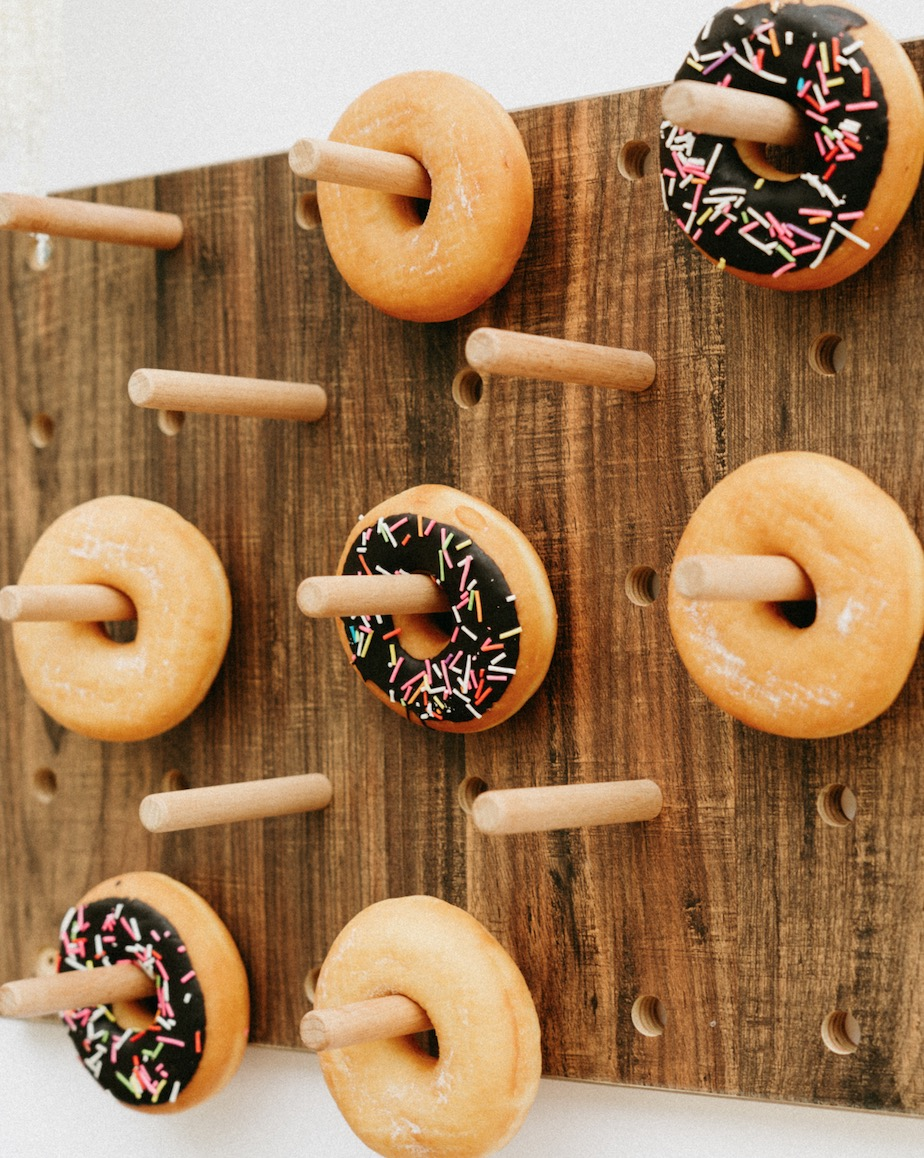

Caption: a group of donuts sitting on a wooden cutting board


In [11]:
display(image)
print('Caption: {}'.format(result[0]['caption']))

In [12]:
from google.colab import drive
drive.mount('/content/Drive')


Mounted at /content/Drive


In [22]:
import glob
import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode
from utils.eval_utils import eval_caption
filenames = glob.glob("/content/Drive/MyDrive/testdata/*.jpg")
filenames.sort()
for img in filenames:
 input_image = Image.open(img)
 sample = construct_sample(input_image)
 sample = utils.move_to_cuda(sample) if use_cuda else sample
 sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
 with torch.no_grad():
  result, scores = eval_caption(task, generator, models, sample)
 #display(input_image)
  print(img, (result[0]['caption']))
  with open('OFAIC.txt', 'a') as fp:
   fp.write(str([img])+str([(result[0]['caption'])]))
   fp.write('\n')


/content/Drive/MyDrive/testdata/File 001.jpg two men in suits standing at a podium
/content/Drive/MyDrive/testdata/File 002.jpg a group of children sitting at a table in a classroom
/content/Drive/MyDrive/testdata/File 003.jpg three women sitting at a table eating food
/content/Drive/MyDrive/testdata/File 004.jpg a baby in a high chair with food in its mouth
/content/Drive/MyDrive/testdata/File 005.jpg a man and a woman sitting on a couch with a laptop
/content/Drive/MyDrive/testdata/File 006.jpg a group of people walking in the rain with umbrellas
/content/Drive/MyDrive/testdata/File 007.jpg a group of people sitting around a table eating
/content/Drive/MyDrive/testdata/File 008.jpg a little girl sitting at a table with a teddy bear
/content/Drive/MyDrive/testdata/File 009.jpg a group of people getting off of an airplane
/content/Drive/MyDrive/testdata/File 010.jpg a young girl talking on a cell phone
/content/Drive/MyDrive/testdata/File 011.jpg a group of women standing in the rain w